In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers



In [ ]:
def load_and_preprocess_data(debug=False):

    from tensorflow.keras.datasets.fashion_mnist import load_data

# Step-1: load the raw dataset
    (X_train, y_train), (X_test, y_test) = load_data()

    if debug:
        print('Before preprocessing:')
        print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
        print(' - X_test.shape = {}, y_test.shape = {}'.format(X_test.shape, y_test.shape))

# Step-2: split the X_test/y_test dataset into cross-val & test datasets

    # randomly sort X_test/y_test
    indexes = np.arange(X_test.shape[0])
    for _ in range(5): indexes = np.random.permutation(indexes)  # shuffle 5 times!
    X_test = X_test[indexes]
    y_test = y_test[indexes]

    # 'split' into cross-val & test sets (use 6000 records in cross-val set)
    val_count = 8000
    X_val = X_test[:val_count]
    y_val = y_test[:val_count]
    X_test = X_test[val_count:]
    y_test = y_test[val_count:]

    # keep an non pre-processed copy of X_test/y_test for visualization
    test_images, test_labels = X_test.copy(), y_test.copy()

# Step-3: scale the images
    # scale the images to between 0-1
    X_train = X_train.astype('float32') / 255.0
    X_val = X_val.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

# Step-4: reshape the images into 3D tensors so our CNN can consume it
    # reshape the image arrays (make 2D arrays instead of 3D arrays)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

    if debug:
        print('After preprocessing:')
        print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
        print(' - X_val.shape = {}, y_val.shape = {}'.format(X_val.shape, y_val.shape))
        print(' - X_test.shape = {}, y_test.shape = {}'.format(X_test.shape, y_test.shape))
        print(' - test_images.shape = {}, test_labels.shape = {}'.format(test_images.shape,
            test_labels.shape))

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), (test_images, test_labels)

In [ ]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), \
  (test_images, test_labels) = load_and_preprocess_data()

Function created to view sample images

In [ ]:
def display_sample(sample_images, sample_labels, sample_predictions=None, num_rows=5, num_cols=10,
                   plot_title=None, fig_size=None):
    """ display a random selection of images & corresponding labels, optionally with predictions
        The display is laid out in a grid of num_rows x num_col cells
        If sample_predictions are provided, then each cell's title displays the prediction
        (if it matches actual) or actual/prediction if there is a mismatch
    """
    import seaborn as sns
    assert sample_images.shape[0] == num_rows * num_cols

    # a dict to help encode/decode the labels
    FASHION_LABELS = {
        0: 'T-shirt/top',
        1: 'Trouser',
        2: 'Pullover',
        3: 'Dress',
        4: 'Coat',
        5: 'Sandal',
        6: 'Shirt',
        7: 'Sneaker',
        8: 'Bag',
        9: 'Ankle boot',
    }

    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=1.1)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(num_rows, num_cols, figsize=((14, 9) if fig_size is None else fig_size),
            gridspec_kw={"wspace": 0.02, "hspace": 0.30}, squeeze=True)

        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")
                # show selected image
                ax[r, c].imshow(sample_images[image_index], cmap="Greys")

                if sample_predictions is None:
                    # show the actual labels in the cell title
                    title = ax[r, c].set_title("%s" % FASHION_LABELS[sample_labels[image_index]])
                else:
                    # else check if prediction matches actual value
                    true_label = sample_labels[image_index]
                    pred_label = sample_predictions[image_index]
                    prediction_matches_true = (sample_labels[image_index] == sample_predictions[image_index])
                    if prediction_matches_true:
                        # if actual == prediction, cell title is prediction shown in green font
                        title = FASHION_LABELS[true_label]
                        title_color = 'g'
                    else:
                        # if actual != prediction, cell title is actua/prediction in red font
                        title = '%s/%s' % (FASHION_LABELS[true_label], FASHION_LABELS[pred_label])
                        title_color = 'r'
                    # display cell title
                    title = ax[r, c].set_title(title)
                    plt.setp(title, color=title_color)
        # set plot title, if one specified
        if plot_title is not None:
            f.suptitle(plot_title)

        plt.show()
        plt.close()

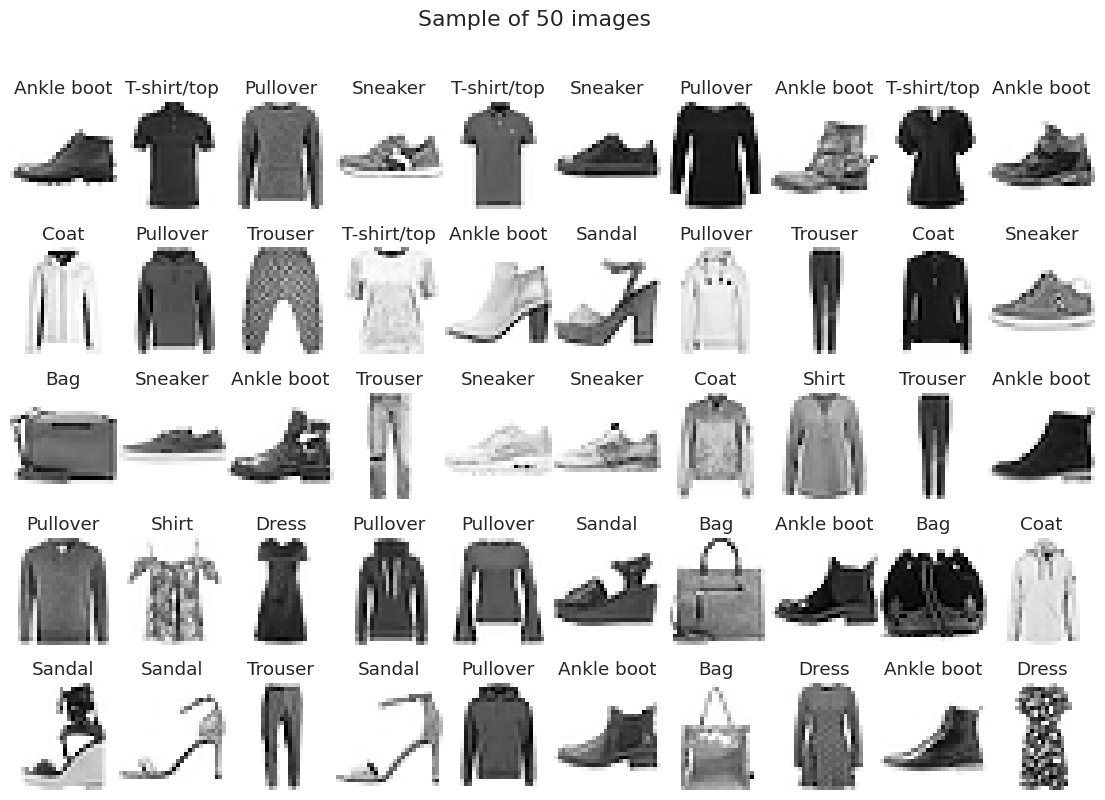

In [ ]:
sample_size = 50
rand_indexes = np.random.randint(0, len(X_test), sample_size)
sample_images = test_images[rand_indexes]
sample_labels = test_labels[rand_indexes]
display_sample(sample_images, sample_labels,
               plot_title='Sample of %d images' % sample_size)

Building the model

In [ ]:
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 28, 28, 1, 10

In [ ]:
def build_model():

    K.clear_session()

    model = Sequential([

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',
               input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS),
               kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Conv2D(64, kernel_size=(3, 3), activation='relu',
               kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),


        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Conv2D(128, kernel_size=(3, 3), activation='relu',
               kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),


        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Conv2D(256, kernel_size=(3, 3), activation='relu',
               kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),


        Flatten(),

        Dense(1024, activation='relu', kernel_regularizer=l2(0.01)),

        Dense(512, activation='relu', kernel_regularizer=l2(0.01)),

        Dense(NUM_CLASSES, activation='softmax')
    ])

    adam = Adam(learning_rate=0.0001)
    model.compile(optimizer=adam,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
model = build_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 26, 26, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                        

Training the model

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))


Epoch 1/20
938/938 [==============================] - 20s 16ms/step - loss: 10.5290 - accuracy: 0.8573 - val_loss: 5.5871 - val_accuracy: 0.8763
Epoch 2/20
938/938 [==============================] - 13s 14ms/step - loss: 3.6103 - accuracy: 0.9067 - val_loss: 2.3801 - val_accuracy: 0.9019
Epoch 3/20
938/938 [==============================] - 13s 14ms/step - loss: 1.7455 - accuracy: 0.9208 - val_loss: 1.4063 - val_accuracy: 0.8938
Epoch 4/20
938/938 [==============================] - 15s 16ms/step - loss: 1.0894 - accuracy: 0.9296 - val_loss: 0.9866 - val_accuracy: 0.9046
Epoch 5/20
938/938 [==============================] - 19s 20ms/step - loss: 0.7999 - accuracy: 0.9353 - val_loss: 0.8017 - val_accuracy: 0.9064
Epoch 6/20
938/938 [==============================] - 16s 17ms/step - loss: 0.6453 - accuracy: 0.9404 - val_loss: 0.7533 - val_accuracy: 0.8925
Epoch 7/20
938/938 [==============================] - 13s 14ms/step - loss: 0.5521 - accuracy: 0.9459 - val_loss: 0.6523 - val_accuracy

In [ ]:
print(history.history)

{'loss': [10.566391944885254, 3.6203439235687256, 1.7543646097183228, 1.097258448600769, 0.811549723148346, 0.6541209816932678, 0.5590673089027405, 0.4919644892215729, 0.44894132018089294, 0.4139539301395416, 0.3862135708332062, 0.3645329475402832, 0.35095369815826416, 0.3346317410469055, 0.32043221592903137, 0.3126429319381714, 0.3053799271583557, 0.299155056476593, 0.29340267181396484, 0.2837393879890442], 'accuracy': [0.8568166494369507, 0.9074000120162964, 0.9205333590507507, 0.9295499920845032, 0.9344833493232727, 0.9399333596229553, 0.9453666806221008, 0.9503166675567627, 0.9541000127792358, 0.9585000276565552, 0.9604666829109192, 0.963783323764801, 0.9652000069618225, 0.9673833250999451, 0.9695500135421753, 0.9711833596229553, 0.972266674041748, 0.9729499816894531, 0.973966658115387, 0.9762666821479797], 'val_loss': [5.572609901428223, 2.3939828872680664, 1.3852206468582153, 0.9721092581748962, 0.7918618321418762, 0.669236958026886, 0.6039599776268005, 0.5709235668182373, 0.5478

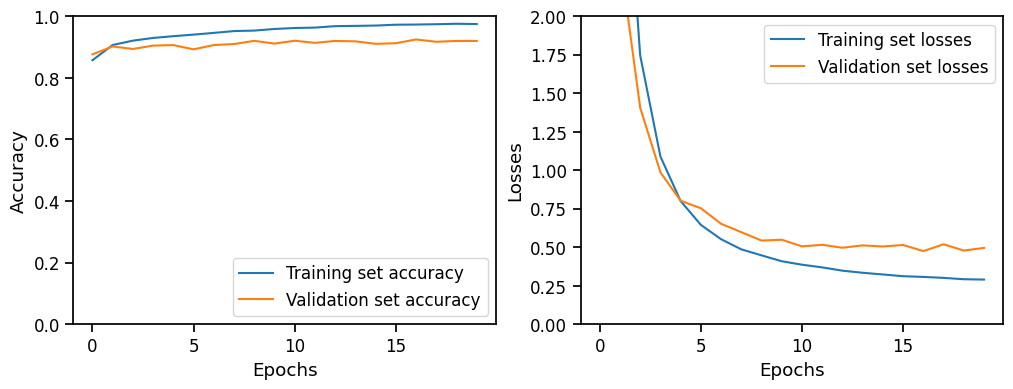

In [ ]:
# Plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training set accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation set accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training set losses')
plt.plot(history.history['val_loss'], label = 'Validation set losses')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.ylim([0, 2])
plt.legend(loc='upper right')

plt.show()

In [ ]:
# Evaluate the model on test data
y_pred = model.predict(X_test)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest set accuracy: {test_acc * 100:.2f}%')

63/63 [==============================] - 0s 4ms/step
63/63 - 0s - loss: 0.5219 - accuracy: 0.9100 - 466ms/epoch - 7ms/step

Test set accuracy: 91.00%


In [ ]:


class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


report = classification_report(y_test, y_pred.argmax(axis=1), target_names=class_names)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

 T-shirt/top       0.83      0.92      0.87       190
     Trouser       0.99      0.99      0.99       208
    Pullover       0.85      0.89      0.87       212
       Dress       0.87      0.94      0.91       221
        Coat       0.88      0.86      0.87       214
      Sandal       0.99      0.97      0.98       179
       Shirt       0.81      0.65      0.72       191
     Sneaker       0.91      1.00      0.95       205
         Bag       0.99      0.96      0.98       190
  Ankle boot       0.99      0.91      0.95       190

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



##Точність (Precision) для кожного класу:

Найвища точність спостерігається для класів "Trouser" (99%), "Sandal" (99%), "Bag" (99%), і "Ankle boot" (99%), що свідчить про добре розпізнавання цих класів моделлю.


Класи "Sneaker" (91%), "Dress" (87%) і "Coat" (88%) також мають хорошу точність, але меншу, ніж вищеназвані класи.


Класи "T-shirt/top" (83%), "Pullover" (85%), і "Shirt" (81%) мають меншу точність, і модель робить більше помилок при розпізнаванні цих класів.


##Повнота (Recall) для кожного класу:

Класи "Trouser" (99%), "Sandal" (97%), "Sneaker" (100%), "Bag" (96%), і "Ankle boot" (91%) мають високу повноту, що означає, що модель добре розпізнає екземпляри цих класів.


Класи "Dress" (94%), "T-shirt/top" (92%), "Pullover" (89%), і "Coat" (86%) також мають досить високу повноту, але меншу, ніж вищеназвані класи.


Клас "Shirt" (65%) має найменшу повноту серед усіх класів, що означає, що модель помиляється при визначенні більшості зразків цього класу.


##F1-рівень (F1-Score):

Загальний F1-рівень для моделі на тестовому наборі становить 0,91, що свідчить про добрі результати класифікації.


Класи з високими F1-рівнями включають "Trouser" (99%), "Sandal" (98%), "Bag" (98%), і "Ankle boot" (95%).


Класи "Dress" (91%), "T-shirt/top" (87%), "Pullover" (87%) і "Coat" (87%) також мають досить високий F1-рівень, але менший, ніж у попередніх.


Клас "Shirt" (72%) має менший F1-рівень, що свідчить про те, що модель не так ефективно розпізнає цей клас.


##Загальна точність (Accuracy):

Загальна точність моделі на тестовому наборі становить 91%, що є досить хорошим результатом.
Узагальнюючи, модель досягла досить хороших результатів на датасеті Fashion MNIST, з загальною точністю близько 91%. Проте важливо звернути увагу на різницю в ефективності розпізнавання різних класів, деякі класи розпізнаються гірше, ніж інші.

Можливо, в подальших етапах можна спробувати покращити роботу моделі шляхом оптимізації гіперпараметрів або додаткового навчання на даних.